# Iteration 1

## Model Architecture

In this section we will define a convolutional neural network (CNN) that predicts the animals shown on a image, as well as the counts for each animal.  Because our CNN is supposed to produce two different kinds of outputs (animal class identifications and animal counts for each class) our CNN needs to be structured accordingly.


Skim through the Introduction section and read section 3.1 of the paper [*Learn to Classify and Count: A Unified Framework for Object Classification and Counting*](https://dl.acm.org/doi/abs/10.1145/3191442.3191459) by Song and Qui.  This should give you a better idea of the structure of the network that we are going to build since our CNN will have an architecture similar to the network in the paper but simpler.  Following similar steps as the ones in the paper, we will build a CNN that has 2 output branches.  Just as the method described in the paper, we will train the upstream layers jointly.  However, instead of using the famous [VGG-16](https://builtin.com/machine-learning/vgg16) network architecture for the upstream layers, we will only borrow the architecture of the first few layers of VGG-16.  This is because VGG-16 has approximately 138 millions of hyperparameters and it will take a long time to train the entire VGG-16.  

The code in the next cell provides you the partial code for building the network for this project.  Please fill in the parts labeled with `...`.  There might be more than one entry needed for each `...`.  You can assume that the input images are of size 128 x 128.

[Batch normalization](https://datahacker.rs/017-pytorch-how-to-apply-batch-normalization-in-pytorch/) is a popular technique used for improving deep neural network performance.  We will use the [torch.nn.BatchNorm2d() function](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) to do batch normalization and keep the default values for its input arguments.  Note that batch normalization does not change the shape of its input or output.

Just a reminder: The `nn.Sequential()` function was discussed in Chapter 8.5 of the lecture notes.

I have described the architecture of the network below:

For **block 1**:

* first layer:
    + a convolutional layer with 64 channels with (5 x 5) filters (kernels) with no padding; batch normalization; activation function: relu.

* second layer:
    + a convolutional layer with 64 channels with (5 x 5) filters; batch normalization; activation function: relu.
    + a maximum pooling layer with (2 x 2 filter), each time move the filter 2 steps when moving horizontally and vertically, no padding


For **block 2**:

* first layer:
    + a convolutional layer with 128 channels with (5 x 5) filters with no padding; batch normalization; activation function: relu.

* second layer:
    + a convolutional layer with 128 channels with (5 x 5) filters with no padding; batch normalization; activation function: relu.
    + a maximum pooling layer with (2 x 2 filter), each time move the filter 2 steps when moving horizontally and vertically, no padding


For each of the **branches**

The following two layers are coded with the *self.branches.append()* function

* first layer:
    + a convolutional layer with 128 channels with (3 x 3) filters with one row/column of zeros added to all four sides of the input; batch normalization; activation function: relu.

* second layer:
    + a convolutional layer with 128 channels with (3 x 3) filters with one row/column of zeros added to all four sides of the input; batch normalization; activation function: relu.
    + a maximum pooling layer with (2 x 2 filter), each time move the filter 2 steps when moving horizontally and vertically, no padding

Third layer: flatten

The following layers are coded with the *self.outputs.append()* function


* fourth layer:
    + dense layer with 256 neurons; activation function: relu
    + dropout rate: 50%

    
* output layer.




In [3]:
from model import VGG16Counting
from utils import train

Note that the loss function is defined to be the sum of two loss functions: `MSELoss()` and `BCEWithLogitsLoss()`.  This is inspired by the loss function used in the paper by Song and Qui. These are natural choices for (1) the regression task and (2) the classification task. The use of `BCEWithLogitsLoss()` (instead of `nn.CrossEntropyLoss()`) means that we use the sigmoid function (instead of the softmax function) as the activation function for the last layer of the classification branch. This is better suited to our dataset since there are many images with more than one type of animal present. Softmax would force the class probabilities to sum to 1, but our dataset does not have mutually exclusive labels.

## Initial Training

In [2]:
# Dataloaders
from dataset import ClassifyCountDataset
from torch.utils.data import DataLoader

train_dataset = ClassifyCountDataset(dataset_type = 'train', img_size = 128)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ClassifyCountDataset(dataset_type = 'val', img_size = 128)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

We initiate the model and define the optimizer below.

In [ ]:
import torch
torch.manual_seed(2023)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = VGG16Counting(num_classes=6).to(device)
save_path = ''
roc_aucs_by_epoch, mses_by_epoch = train(
    model1, train_dataloader, val_dataloader, save_path=save_path)

## Determining Optimal Epoch for Full Train-Validation Training

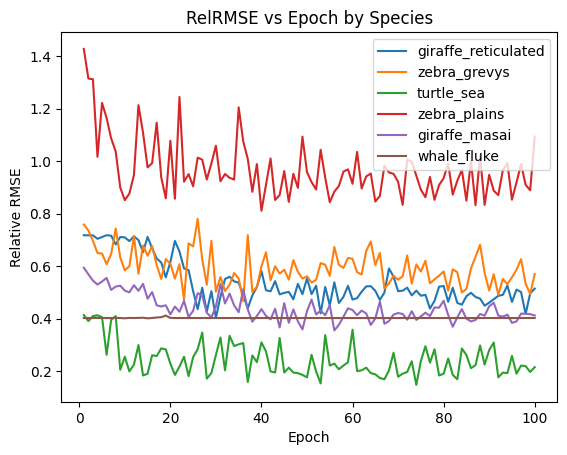

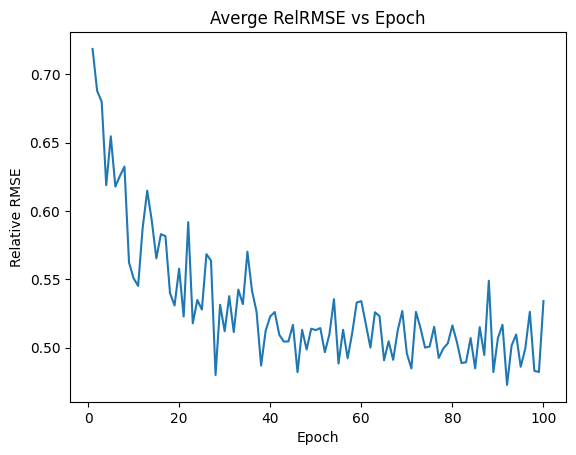

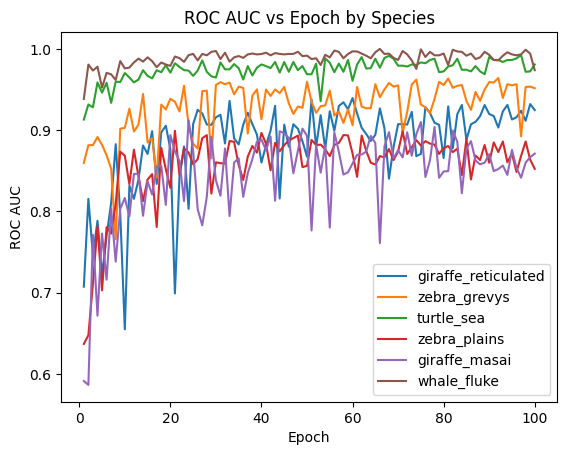

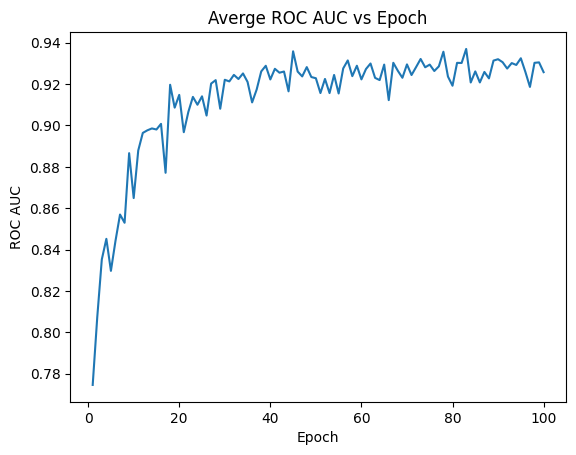

In [ ]:
from utils import epoch_graphs
epoch_graphs(roc_aucs_by_epoch, mses_by_epoch)

Average RelRMSE drops until about epoch 40 and then gently falls until around epoch 80, where it starts to become unstable. Average ROC AUC increases quickly until about epoch 20 and then slowly increases until around epoch 80. So, we chose 80 for the number of epochs to train our champion model.

## Training on Full Train-Val Dataset

In [ ]:
# Create dataloader
nontest_dataset = ClassifyCountDataset(dataset_type = 'trainval', img_size = 128)
test_dataset = ClassifyCountDataset(dataset_type = 'test', img_size = 128)

nontest_dataloader = DataLoader(nontest_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
torch.manual_seed(2023)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bestmodel1 = VGG16Counting(num_classes=6).to(device)

In [ ]:
champ_num_epochs = 80
roc_aucs_on_test, relrmses_on_test = train(bestmodel1, nontest_dataloader,
                                           test_dataloader, num_epochs = champ_num_epochs)

In [ ]:
from utils import display_results
# Displaying Test Scores
final_relrmses = relrmses_on_test[champ_num_epochs - 1, :]
final_roc_aucs = roc_aucs_on_test[champ_num_epochs - 1, :]
display_results(final_relrmses, final_roc_aucs)

RelRMSE = 0.63  & ROC AUC = 0.92  : giraffe_reticulated
RelRMSE = 0.64  & ROC AUC = 0.96  : zebra_grevys
RelRMSE = 0.42  & ROC AUC = 0.99  : turtle_sea
RelRMSE = 0.91  & ROC AUC = 0.88  : zebra_plains
RelRMSE = 0.51  & ROC AUC = 0.91  : giraffe_masai
RelRMSE = 0.26  & ROC AUC = 0.99  : whale_fluke
RelRMSE = 0.56  & ROC AUC = 0.94  : average


# Iteration 2

In [ ]:
import torch
torch.manual_seed(2023)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = VGG16Counting(num_classes=6, add_se=True).to(device)

save_path = ''
roc_aucs_by_epoch, mses_by_epoch = train(
    model2, train_dataloader, val_dataloader, save_path=save_path)

epoch_graphs(roc_aucs_by_epoch, mses_by_epoch)

In [ ]:
torch.manual_seed(2023)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bestmodel2 = VGG16Counting(num_classes=6, add_se=True).to(device)
champ_num_epochs = 80

roc_aucs_on_test, relrmses_on_test = train(bestmodel2, 
                                           nontest_dataloader,
                                           test_dataloader, 
                                           num_epochs=champ_num_epochs)

final_relrmses = relrmses_on_test[champ_num_epochs - 1, :]
final_roc_aucs = roc_aucs_on_test[champ_num_epochs - 1, :]
display_results(final_relrmses, final_roc_aucs)

# Iteration 3

In [5]:
train_dataset = ClassifyCountDataset(dataset_type='train', img_size=128, stdevs=True)
val_dataset = ClassifyCountDataset(dataset_type='val', img_size=128, stdevs=True)
nontest_dataset = ClassifyCountDataset(dataset_type='trainval', img_size=128, stdevs=True)
test_dataset = ClassifyCountDataset(dataset_type='test', img_size=128, stdevs=True)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
nontest_dataloader = DataLoader(nontest_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

NameError: name 'ClassifyCountDataset' is not defined

In [ ]:
import torch
torch.manual_seed(2023)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3 = VGG16Counting(num_classes=6, add_se=True).to(device)

save_path = ''
roc_aucs_by_epoch, mses_by_epoch = train(model3, 
                                         train_dataloader, 
                                         val_dataloader, 
                                         save_path=save_path, 
                                         ratio=10, stdevs=True)

epoch_graphs(roc_aucs_by_epoch, mses_by_epoch)

In [ ]:
torch.manual_seed(2023)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bestmodel3 = VGG16Counting(num_classes=6, add_se=True).to(device)
champ_num_epochs = 80

roc_aucs_on_test, relrmses_on_test = train(bestmodel3,
                                           nontest_dataloader,
                                           test_dataloader,
                                           num_epochs=champ_num_epochs,
                                           ratio=10, stdevs=True)

final_relrmses = relrmses_on_test[champ_num_epochs - 1, :]
final_roc_aucs = roc_aucs_on_test[champ_num_epochs - 1, :]
display_results(final_relrmses, final_roc_aucs)